In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.metrics import Precision, Recall,AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
# setup
# Paths to data splits
TRAIN_DIR = "../data/train"
VAL_DIR = "../data/val"
TEST_DIR = "../data/test"

# Image parameters
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Detect classes automatically
classes = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(classes)

print(f"Detected classes ({NUM_CLASSES}): {classes}")

Detected classes (2): ['normal', 'yawn']


Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


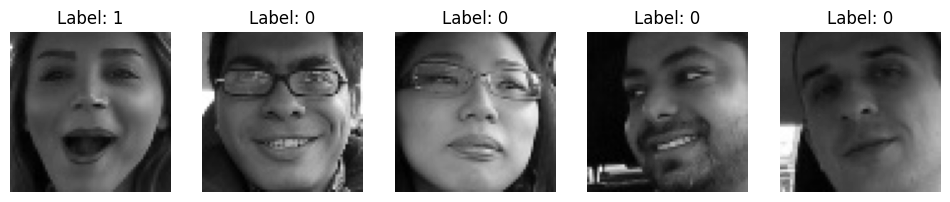

In [4]:
# Load images with ImageDataGenerator (Binary classification)

# Rescale only
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Preview a few training images
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(x_batch[i].reshape(IMG_SIZE), cmap="gray")
    axes[i].set_title(f"Label: {int(y_batch[i])}")
    axes[i].axis("off")

plt.show()


In [5]:
print(train_generator.class_indices)

{'normal': 0, 'yawn': 1}


In [6]:
model = Sequential([
    Conv2D(32, (3,3), padding="same", activation="relu",
           input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])


d:\SPU\5th s1 Lectures\Junior Project\code\mediapipe_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        "acc",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name='auc')
    ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,438,849 (5.49 MB)

 Trainable params: 1,437,889 (5.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
os.environ["WANDB_API_KEY"] = "cd71d6f2249981dffae87be7baa57f08fe64c95e"
os.environ["WANDB_MODE"] = "online"

In [9]:
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [10]:
print(wandb.__version__)
print(os.environ.get("WANDB_API_KEY"))

0.23.1
cd71d6f2249981dffae87be7baa57f08fe64c95e


In [11]:
wandb.init(
    project="driver-drowsiness-cnn",
    name="cnn_v2",
    config={
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "epochs": 30,
        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "architecture": "CNN_v2"
    }
)

wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
early_stop = EarlyStopping(
    monitor="val_auc",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = WandbModelCheckpoint(
    filepath="../models/cnn_v2/best.keras", 
    monitor="val_auc",
    save_best_only=True
)


wandb_metrics = WandbMetricsLogger()

callbacks = [
    early_stop,
    checkpoint,
    wandb_metrics
]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [13]:
class_weights_dict = {
    0: 0.702,  # Normal
    1: 1.737   # Yawn
}
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights_dict
)
wandb.finish()

d:\SPU\5th s1 Lectures\Junior Project\code\mediapipe_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 986ms/step - acc: 0.6745 - auc: 0.7261 - loss: 0.7921 - precision: 0.4270 - recall: 0.6345 - val_acc: 0.4938 - val_auc: 0.6014 - val_loss: 0.6943 - val_precision: 0.3140 - val_recall: 0.7431
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - acc: 0.8676 - auc: 0.9418 - loss: 0.3053 - precision: 0.7281 - recall: 0.8418 - val_acc: 0.7309 - val_auc: 0.6263 - val_loss: 0.6261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - acc: 0.9303 - auc: 0.9715 - loss: 0.2036 - precision: 0.8496 - recall: 0.8802 - val_acc: 0.7309 - val_auc: 0.6639 - val_loss: 0.5634 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 920ms/step - acc: 0.9372 - auc: 0.9815 - loss: 0.1757 - precision: 0.8614 - recall: 0.9175 - val_acc: 0.7309 - val_auc: 0.7609 - val_loss: 0.5720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/ste

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - acc: 0.9500 - auc: 0.9893 - loss: 0.1345 - precision: 0.8823 - recall: 0.9503 - val_acc: 0.7309 - val_auc: 0.7873 - val_loss: 0.5297 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - acc: 0.9694 - auc: 0.9948 - loss: 0.0969 - precision: 0.9221 - recall: 0.9636 - val_acc: 0.7309 - val_auc: 0.8367 - val_loss: 0.5217 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 902ms/step - acc: 0.9703 - auc: 0.9958 - loss: 0.0876 - precision: 0.9314 - recall: 0.9586 - val_acc: 0.7679 - val_auc: 0.8790 - val_loss: 0.4959 - val_precision: 1.0000 - val_recall: 0.1376
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 887ms/step - acc: 0.9841 - auc: 0.9982 - loss: 0.0611 - precision: 0.9578 - recall: 0.9871 - val_acc: 0.8346 - val_auc: 0.8912 - val_loss: 0.4470 - val_precision: 0.9375 - val_recall: 0.4128
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 947ms/step - acc: 0.9799 - 

epoch/acc,▁▅▆▆▇▇▇█▇█▇█████▇▇███████████
epoch/auc,▁▆▇▇█████████████████████████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▁▄▅▆▆▇▇▇▇▇▆▇██▇█▇▇███████████
epoch/recall,▁▄▅▆▆▇▇███▇███▇██▇███████████
epoch/val_acc,▁▅▅▅▅▅▆▇▇████████████████████
epoch/val_auc,▁▂▂▄▅▆▇▇▇▇▇█▇████████████████
epoch/val_loss,█▇▅▆▅▅▄▃▁▁▁▂▃▃▃▃▃▃▃▄▄▅▅▄▅▅▅▆▆
+2,...


In [14]:
# Evaluate model on test data
test_results = model.evaluate(test_generator, verbose=1)

for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - acc: 0.9635 - auc: 0.3353 - loss: 0.1978 - precision: 0.3028 - recall: 0.3005    
loss: 0.3923
compile_metrics: 0.9337


In [15]:
# Reset generator to avoid index mismatch
test_generator.reset()

# Predict probabilities
y_prob = model.predict(test_generator, verbose=1).ravel()

# True labels
y_true = test_generator.classes


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step


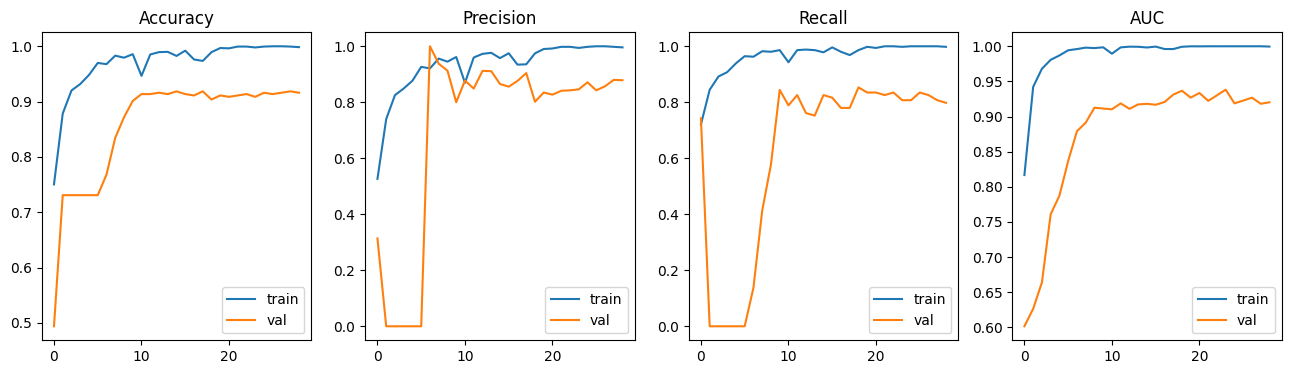

In [16]:
# Plot training history
plt.figure(figsize=(16,4))

# Accuracy
plt.subplot(1,4,1)
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.title('Accuracy')
plt.legend()

# Precision
plt.subplot(1,4,2)
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='val')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(1,4,3)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
plt.title('Recall')
plt.legend()

# AUC
plt.subplot(1,4,4)
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='val')
plt.title('AUC')
plt.legend()

plt.show()


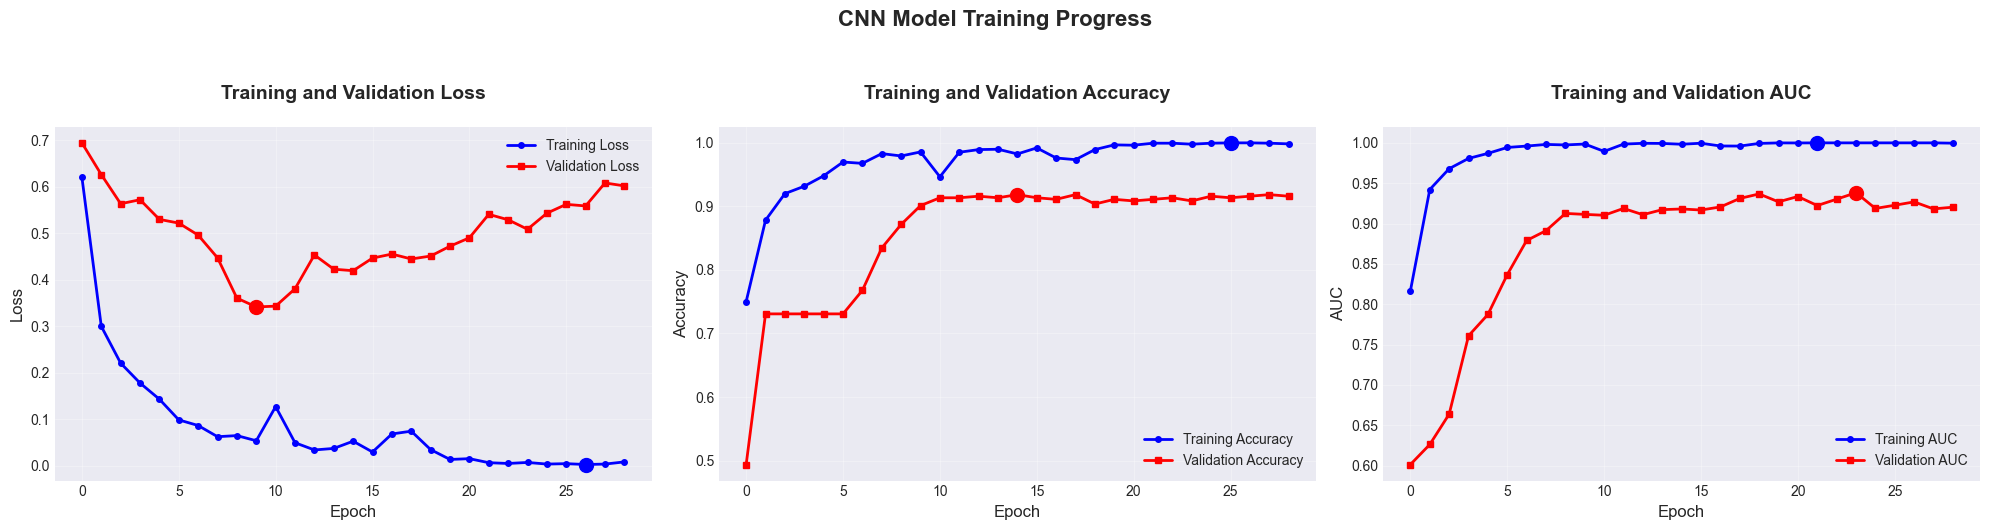

In [17]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Plot 1: Loss, Accuracy, AUC
plt.figure(figsize=(20, 5))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
plt.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
plt.scatter(history.history['loss'].index(min_train_loss), min_train_loss, color='blue', s=100, zorder=5)
plt.scatter(history.history['val_loss'].index(min_val_loss), min_val_loss, color='red', s=100, zorder=5)
plt.legend(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], 'b-', linewidth=2, label='Training Accuracy', marker='o', markersize=4)
plt.plot(history.history['val_acc'], 'r-', linewidth=2, label='Validation Accuracy', marker='s', markersize=4)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.scatter(history.history['acc'].index(max(history.history['acc'])), max(history.history['acc']), color='blue', s=100, zorder=5)
plt.scatter(history.history['val_acc'].index(max(history.history['val_acc'])), max(history.history['val_acc']), color='red', s=100, zorder=5)
plt.legend(fontsize=10)

# Subplot 3: AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], 'b-', linewidth=2, label='Training AUC', marker='o', markersize=4)
plt.plot(history.history['val_auc'], 'r-', linewidth=2, label='Validation AUC', marker='s', markersize=4)
plt.title('Training and Validation AUC', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.grid(True, alpha=0.3)
plt.scatter(history.history['auc'].index(max(history.history['auc'])), max(history.history['auc']), color='blue', s=100, zorder=5)
plt.scatter(history.history['val_auc'].index(max(history.history['val_auc'])), max(history.history['val_auc']), color='red', s=100, zorder=5)
plt.legend(fontsize=10)

plt.suptitle('CNN Model Training Progress', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


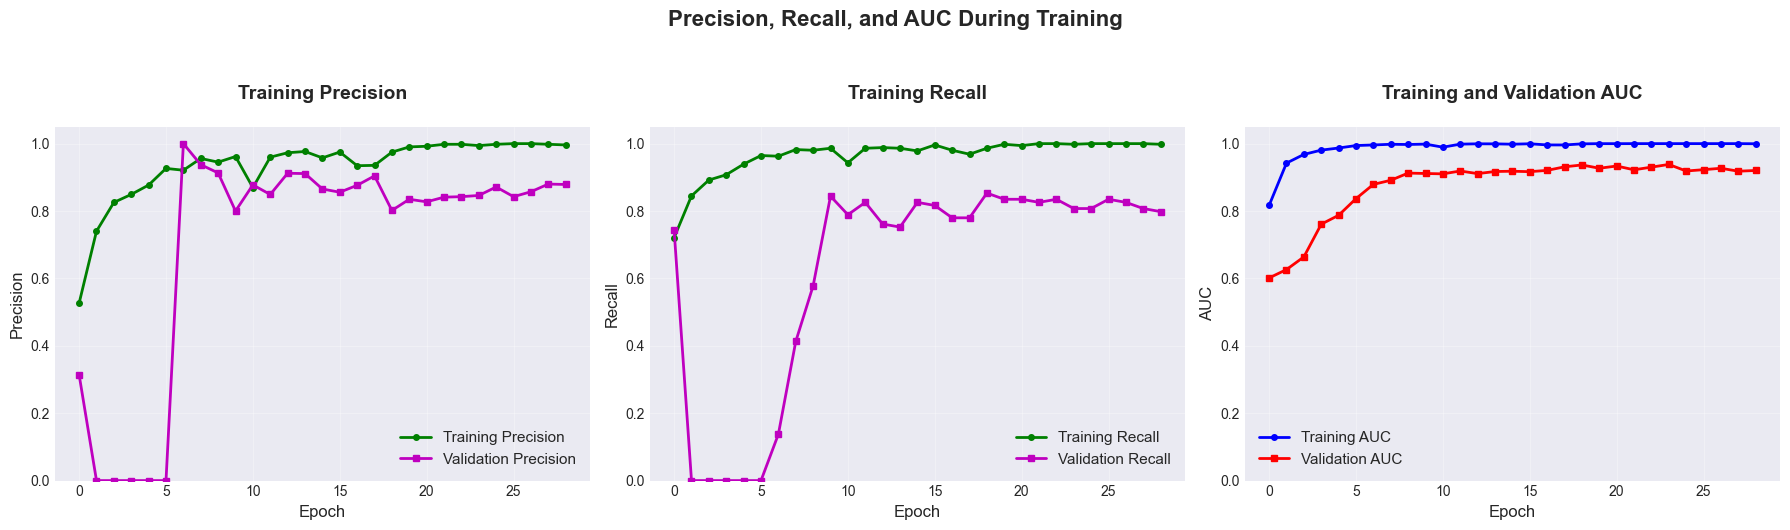

In [18]:
plt.figure(figsize=(18, 5))

# Subplot 1: Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], 'g-', linewidth=2, label='Training Precision', marker='o', markersize=4)
plt.plot(history.history['val_precision'], 'm-', linewidth=2, label='Validation Precision', marker='s', markersize=4)
plt.title('Training Precision', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

# Subplot 2: Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], 'g-', linewidth=2, label='Training Recall', marker='o', markersize=4)
plt.plot(history.history['val_recall'], 'm-', linewidth=2, label='Validation Recall', marker='s', markersize=4)
plt.title('Training Recall', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

# Subplot 3: AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], 'b-', linewidth=2, label='Training AUC', marker='o', markersize=4)
plt.plot(history.history['val_auc'], 'r-', linewidth=2, label='Validation AUC', marker='s', markersize=4)
plt.title('Training and Validation AUC', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

plt.suptitle('Precision, Recall, and AUC During Training', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


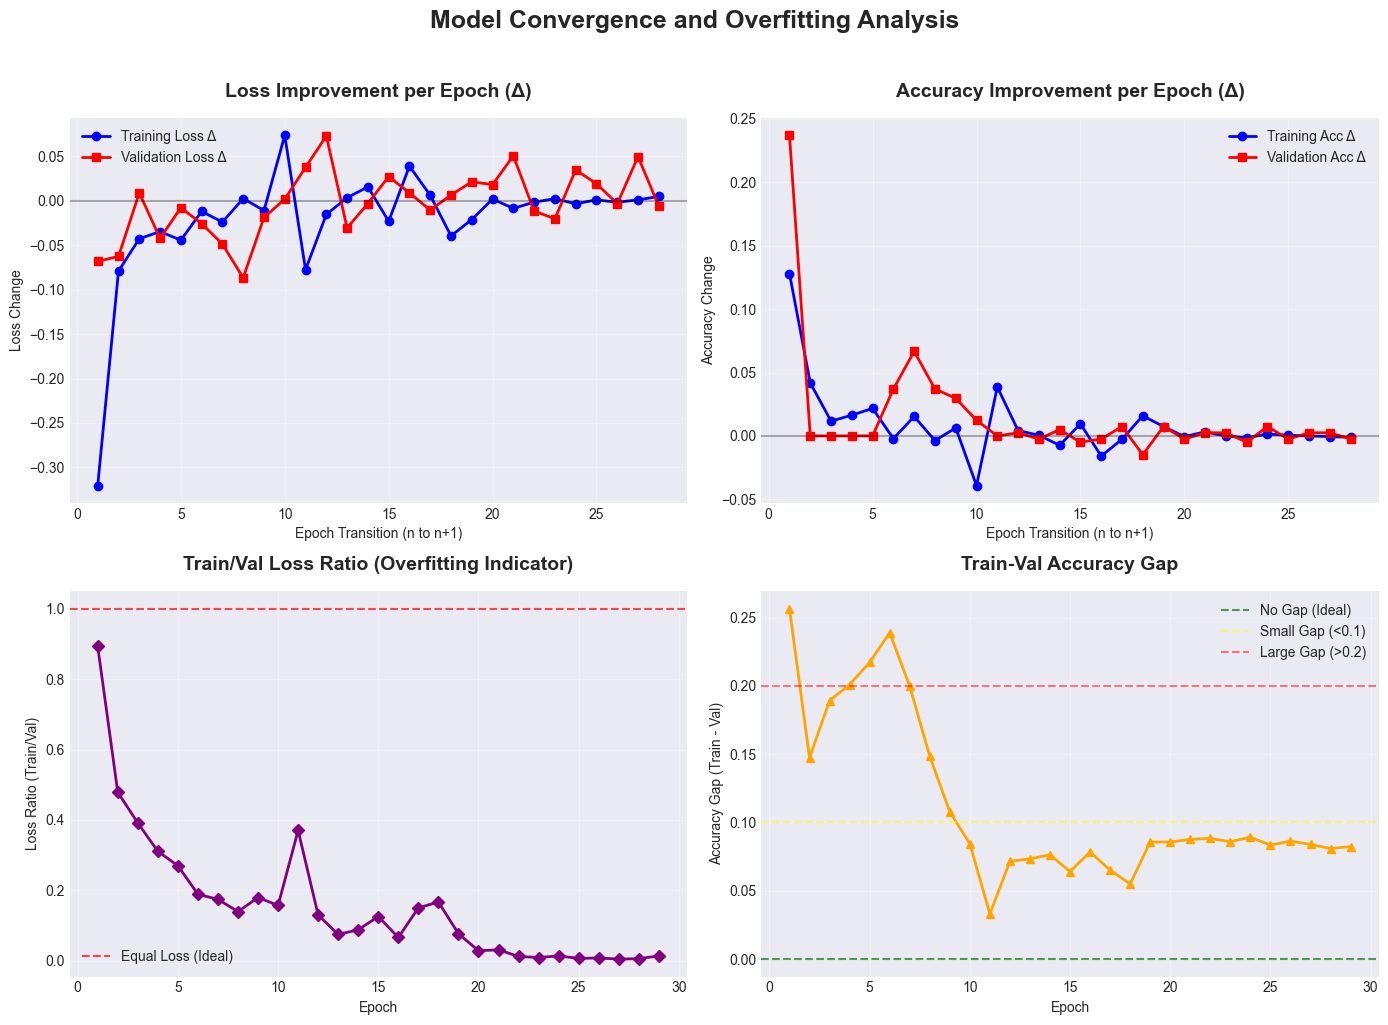

In [20]:
# Analyze convergence by looking at differences between epochs
plt.figure(figsize=(14, 10))
epochs = 29

# Calculate differences between consecutive epochs
train_loss_diff = np.diff(history.history['loss'])
val_loss_diff = np.diff(history.history['val_loss'])
train_acc_diff = np.diff(history.history['acc'])
val_acc_diff = np.diff(history.history['val_acc'])

epochs_diff = range(1, epochs)  # One less epoch for differences

# Subplot 1: Loss differences (convergence rate)
plt.subplot(2, 2, 1)
plt.plot(epochs_diff, train_loss_diff, 'b-', linewidth=2, label='Training Loss Δ', marker='o')
plt.plot(epochs_diff, val_loss_diff, 'r-', linewidth=2, label='Validation Loss Δ', marker='s')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Loss Improvement per Epoch (Δ)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch Transition (n to n+1)')
plt.ylabel('Loss Change')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Accuracy differences
plt.subplot(2, 2, 2)
plt.plot(epochs_diff, train_acc_diff, 'b-', linewidth=2, label='Training Acc Δ', marker='o')
plt.plot(epochs_diff, val_acc_diff, 'r-', linewidth=2, label='Validation Acc Δ', marker='s')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Accuracy Improvement per Epoch (Δ)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch Transition (n to n+1)')
plt.ylabel('Accuracy Change')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Loss ratio (train/val) - Overfitting indicator
plt.subplot(2, 2, 3)
loss_ratio = [t/v if v != 0 else 0 for t, v in zip(history.history['loss'], history.history['val_loss'])]
plt.plot(range(1, epochs+1), loss_ratio, color='purple', linewidth=2, marker='D')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal Loss (Ideal)')
plt.title('Train/Val Loss Ratio (Overfitting Indicator)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Loss Ratio (Train/Val)')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 4: Gap between train and validation accuracy
plt.subplot(2, 2, 4)
acc_gap = [t - v for t, v in zip(history.history['acc'], history.history['val_acc'])]
plt.plot(range(1, epochs+1), acc_gap, color='orange', linewidth=2, marker='^')
plt.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='No Gap (Ideal)')
plt.axhline(y=0.1, color='yellow', linestyle='--', alpha=0.5, label='Small Gap (<0.1)')
plt.axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Large Gap (>0.2)')
plt.title('Train-Val Accuracy Gap', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (Train - Val)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.suptitle('Model Convergence and Overfitting Analysis', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [23]:
#  full classification report
y_pred = (y_prob > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))



Classification Report:
              precision    recall  f1-score   support

      normal       0.94      0.97      0.96       297
        yawn       0.91      0.84      0.87       110

    accuracy                           0.93       407
   macro avg       0.93      0.90      0.91       407
weighted avg       0.93      0.93      0.93       407



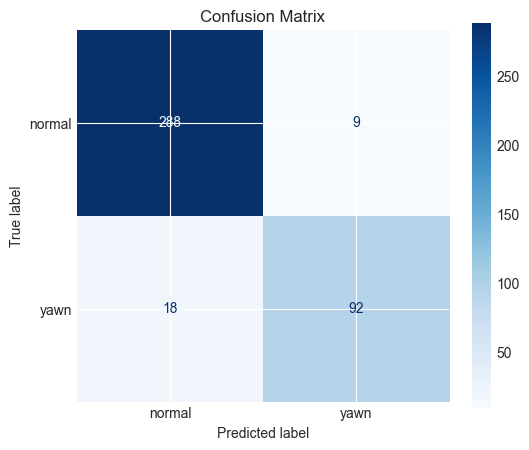

In [24]:
# Plot confusion matrix 

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


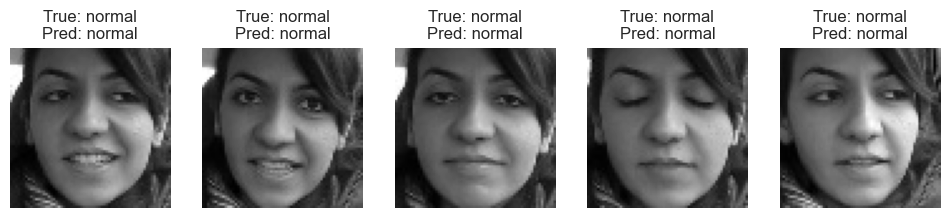

In [25]:
# Sample Predictions – display test images with predicted vs true labels
x_test, y_test = next(test_generator)  # batch from test generator
y_pred_sample = (model.predict(x_test) > 0.5).astype(int).reshape(-1)

# Convert true labels to integers
y_test_int = y_test.astype(int)

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_test[i].reshape(IMG_SIZE), cmap='gray')
    axes[i].set_title(f"True: {classes[y_test_int[i]]}\nPred: {classes[y_pred_sample[i]]}")
    axes[i].axis('off')
plt.show()


In [ ]:
import pickle

with open("../models/cnn_v2/history.pkl", "wb") as f:
    pickle.dump(history.history, f)
